In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load MovieLens 100K data
ratings_train = pd.read_csv('ml-100k/u1.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_test = pd.read_csv('ml-100k/u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
items = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None)
P = items.iloc[:, 5:24].values  # Item features (genres), shape (num_items, 19)

# Get dimensions
num_users = max(ratings_train['user_id'].max(), ratings_test['user_id'].max())
num_items = max(ratings_train['item_id'].max(), ratings_test['item_id'].max())

# Create rating matrix R with missing values as 0
R = np.zeros((num_users, num_items))
for row in ratings_train.itertuples():
    R[row.user_id - 1, row.item_id - 1] = row.rating

# Create mask for observed ratings in training set
mask_train = np.zeros((num_users, num_items), dtype=bool)
for row in ratings_train.itertuples():
    mask_train[row.user_id - 1, row.item_id - 1] = True

# Define User Autoencoder
class UserAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(UserAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        z = F.relu(self.encoder(x))
        output = self.decoder(z)
        output = 1 + 4 * torch.sigmoid(output)  # Scale to [1, 5]
        return output

# Define Item Autoencoder
class ItemAutoencoder(nn.Module):
    def __init__(self, input_dim_user_ratings, input_dim_item_features, hidden_dim):
        super(ItemAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim_user_ratings + input_dim_item_features, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim_user_ratings)

    def forward(self, x_ratings, x_features):
        x = torch.cat([x_ratings, x_features], dim=1)
        z = F.relu(self.encoder(x))
        output = self.decoder(z)
        output = 1 + 4 * torch.sigmoid(output)  # Scale to [1, 5]
        return output

# Define datasets
class UserDataset(Dataset):
    def __init__(self, R, mask):
        self.R = R
        self.mask = mask

    def __len__(self):
        return len(self.R)

    def __getitem__(self, idx):
        return torch.tensor(self.R[idx], dtype=torch.float32), torch.tensor(self.mask[idx], dtype=torch.bool)

class ItemDataset(Dataset):
    def __init__(self, R, P, mask):
        self.R = R.T  # (num_items, num_users)
        self.P = P  # (num_items, num_features)
        self.mask = mask.T  # (num_items, num_users)

    def __len__(self):
        return len(self.R)

    def __getitem__(self, idx):
        return torch.tensor(self.R[idx], dtype=torch.float32), torch.tensor(self.P[idx], dtype=torch.float32), torch.tensor(self.mask[idx], dtype=torch.bool)

# Training function for autoencoders
def train_autoencoder(model, dataloader, num_epochs, learning_rate, model_name):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)  # Use Adam with weight decay
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for data in dataloader:
            if len(data) == 2:
                x, m = data
                x = x.to(device)
                m = m.to(device)
                output = model(x)
                loss = F.mse_loss(output[m], x[m], reduction='sum') / m.sum()  # Normalize by number of observed ratings
            else:
                x_ratings, x_features, m = data
                x_ratings = x_ratings.to(device)
                x_features = x_features.to(device)
                m = m.to(device)
                output = model(x_ratings, x_features)
                loss = F.mse_loss(output[m], x_ratings[m], reduction='sum') / m.sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"{model_name} - Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
d = 150  # Increased latent dimension
learning_rate = 0.001  # Lower learning rate
num_epochs = 200  # More epochs
learning_rate_mf = 0.0005  # Lower learning rate for MF
num_epochs_mf = 20  # More epochs for MF
C = 1.0  # Gradient clipping norm
epsilon = 5.0  # Total privacy budget
lambda_v = 0.1  # Increased regularization
b = C / (epsilon / num_epochs_mf)  # Adjusted noise scale for more epochs

# Train user autoencoder
model_user = UserAutoencoder(input_dim=num_items, hidden_dim=d).to(device)
dataset_user = UserDataset(R=R, mask=mask_train)
dataloader_user = DataLoader(dataset_user, batch_size=64, shuffle=True)  # Larger batch size
train_autoencoder(model_user, dataloader_user, num_epochs, learning_rate, model_name="UserAE")

# Train item autoencoder
model_item = ItemAutoencoder(input_dim_user_ratings=num_users, input_dim_item_features=19, hidden_dim=d).to(device)
dataset_item = ItemDataset(R=R, P=P, mask=mask_train)
dataloader_item = DataLoader(dataset_item, batch_size=64, shuffle=True)
train_autoencoder(model_item, dataloader_item, num_epochs, learning_rate, model_name="ItemAE")

# Extract latent factors
with torch.no_grad():
    R_tensor = torch.tensor(R, dtype=torch.float32).to(device)
    U = model_user.encoder(R_tensor).cpu().numpy()  # User latent factors
    item_inputs = np.concatenate([R.T, P], axis=1)
    item_inputs_tensor = torch.tensor(item_inputs, dtype=torch.float32).to(device)
    V = model_item.encoder(item_inputs_tensor).cpu().numpy()  # Initial item latent factors

# Evaluate function for test set
def evaluate(U, V, ratings_test):
    test_pred = []
    test_true = []
    for row in ratings_test.itertuples():
        i = row.user_id - 1
        j = row.item_id - 1
        pred = np.dot(U[i], V[j])
        pred = np.clip(pred, 1, 5)  # Clip predictions to [1, 5]
        test_pred.append(pred)
        test_true.append(row.rating)
    rmse = np.sqrt(mean_squared_error(test_true, test_pred))
    mae = mean_absolute_error(test_true, test_pred)
    return rmse, mae

# Initial evaluation
initial_rmse, initial_mae = evaluate(U, V, ratings_test)
print(f"Initial Evaluation -> RMSE: {initial_rmse:.4f}, MAE: {initial_mae:.4f}")

# Train V with differentially private SGD, with logging
rmse_values = [initial_rmse]
mae_values = [initial_mae]
v_norms = [np.linalg.norm(V, axis=1).mean()]

for epoch in range(num_epochs_mf):
    shuffled_ratings_train = ratings_train.sample(frac=1).reset_index(drop=True)
    for row in shuffled_ratings_train.itertuples():
        i = row.user_id - 1
        j = row.item_id - 1
        r = row.rating
        pred = np.dot(U[i], V[j])
        # Only update for observed ratings
        if mask_train[i, j]:
            e = r - pred
        else:
            e = 0
        g_j = -2 * e * U[i] + lambda_v * V[j]  # Gradient
        norm_g_j = np.linalg.norm(g_j)
        if norm_g_j > C:
            g_j = g_j * (C / norm_g_j)  # Clip gradient
        noise = np.random.laplace(0, b, size=d)  # Add Laplace noise
        g_j_noisy = g_j + noise
        V[j] -= learning_rate_mf * g_j_noisy  # Update V
    rmse, mae = evaluate(U, V, ratings_test)
    rmse_values.append(rmse)
    mae_values.append(mae)
    v_norms.append(np.linalg.norm(V, axis=1).mean())
    print(f"Matrix Factorization - Epoch {epoch+1}/{num_epochs_mf}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, V Norm: {v_norms[-1]:.4f}")

# Final evaluation
final_rmse, final_mae = evaluate(U, V, ratings_test)
print(f"Final Evaluation -> RMSE: {final_rmse:.4f}, MAE: {final_mae:.4f}")

# Visualizations
plt.figure(figsize=(15, 5))

# Plot 1: RMSE Over Epochs
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs_mf + 1), rmse_values, marker='o', label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.grid(True)
plt.legend()

# Plot 2: MAE Over Epochs
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs_mf + 1), mae_values, marker='o', label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE Over Epochs')
plt.grid(True)
plt.legend()

# Plot 3: V Norm Over Epochs
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs_mf + 1), v_norms, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average V Norm')
plt.title('V Norm Over Epochs')
plt.grid(True)

plt.tight_layout()
plt.savefig('dp_ae_metrics_corrected.png')
plt.close()

UserAE - Epoch 1/200, Loss: 20.3226
UserAE - Epoch 2/200, Loss: 15.4634
UserAE - Epoch 3/200, Loss: 13.9134
UserAE - Epoch 4/200, Loss: 13.1813
UserAE - Epoch 5/200, Loss: 12.5136
UserAE - Epoch 6/200, Loss: 11.9996
UserAE - Epoch 7/200, Loss: 11.5649
UserAE - Epoch 8/200, Loss: 11.1909
UserAE - Epoch 9/200, Loss: 10.8919
UserAE - Epoch 10/200, Loss: 10.7064
UserAE - Epoch 11/200, Loss: 10.3983
UserAE - Epoch 12/200, Loss: 10.2581
UserAE - Epoch 13/200, Loss: 10.0612
UserAE - Epoch 14/200, Loss: 9.9656
UserAE - Epoch 15/200, Loss: 9.8148
UserAE - Epoch 16/200, Loss: 9.7063
UserAE - Epoch 17/200, Loss: 9.5631
UserAE - Epoch 18/200, Loss: 9.5303
UserAE - Epoch 19/200, Loss: 9.4352
UserAE - Epoch 20/200, Loss: 9.2906
UserAE - Epoch 21/200, Loss: 9.2139
UserAE - Epoch 22/200, Loss: 9.1827
UserAE - Epoch 23/200, Loss: 9.1079
UserAE - Epoch 24/200, Loss: 9.1035
UserAE - Epoch 25/200, Loss: 8.9831
UserAE - Epoch 26/200, Loss: 8.9147
UserAE - Epoch 27/200, Loss: 8.9071
UserAE - Epoch 28/200, L

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load MovieLens 100K data
ratings_train = pd.read_csv('ml-100k/u1.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_test = pd.read_csv('ml-100k/u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
items = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', header=None)
P = items.iloc[:, 5:24].values  # Item features (genres), shape (num_items, 19)

# Get dimensions
num_users = max(ratings_train['user_id'].max(), ratings_test['user_id'].max())
num_items = max(ratings_train['item_id'].max(), ratings_test['item_id'].max())

# Create rating matrix R with missing values as 0
R = np.zeros((num_users, num_items))
for row in ratings_train.itertuples():
    R[row.user_id - 1, row.item_id - 1] = row.rating

# Create mask for observed ratings in training set
mask_train = np.zeros((num_users, num_items), dtype=bool)
for row in ratings_train.itertuples():
    mask_train[row.user_id - 1, row.item_id - 1] = True

# Define Denoising User Autoencoder with deeper architecture
class DenoisingUserAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.2):
        super(DenoisingUserAutoencoder, self).__init__()
        self.encoder1 = nn.Linear(input_dim, 512)
        self.encoder2 = nn.Linear(512, hidden_dim)
        self.decoder1 = nn.Linear(hidden_dim, 512)
        self.decoder2 = nn.Linear(512, input_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x_noisy = self.dropout(x)
        h = F.relu(self.encoder1(x_noisy))
        z = F.relu(self.encoder2(h))
        h = F.relu(self.decoder1(z))
        output = self.decoder2(h)
        output = 1 + 4 * torch.sigmoid(output)  # Scale to [1, 5]
        return output

# Define Denoising Item Autoencoder with deeper architecture
class DenoisingItemAutoencoder(nn.Module):
    def __init__(self, input_dim_user_ratings, input_dim_item_features, hidden_dim, dropout_rate=0.2):
        super(DenoisingItemAutoencoder, self).__init__()
        self.encoder1 = nn.Linear(input_dim_user_ratings + input_dim_item_features, 512)
        self.encoder2 = nn.Linear(512, hidden_dim)
        self.decoder1 = nn.Linear(hidden_dim, 512)
        self.decoder2 = nn.Linear(512, input_dim_user_ratings)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x_ratings, x_features):
        x_ratings_noisy = self.dropout(x_ratings)
        x = torch.cat([x_ratings_noisy, x_features], dim=1)
        h = F.relu(self.encoder1(x))
        z = F.relu(self.encoder2(h))
        h = F.relu(self.decoder1(z))
        output = self.decoder2(h)
        output = 1 + 4 * torch.sigmoid(output)  # Scale to [1, 5]
        return output

# Define datasets
class UserDataset(Dataset):
    def __init__(self, R, mask):
        self.R = R
        self.mask = mask

    def __len__(self):
        return len(self.R)

    def __getitem__(self, idx):
        return torch.tensor(self.R[idx], dtype=torch.float32), torch.tensor(self.mask[idx], dtype=torch.bool)

class ItemDataset(Dataset):
    def __init__(self, R, P, mask):
        self.R = R.T  # (num_items, num_users)
        self.P = P  # (num_items, num_features)
        self.mask = mask.T  # (num_items, num_users)

    def __len__(self):
        return len(self.R)

    def __getitem__(self, idx):
        return torch.tensor(self.R[idx], dtype=torch.float32), torch.tensor(self.P[idx], dtype=torch.float32), torch.tensor(self.mask[idx], dtype=torch.bool)

# Training function for denoising autoencoders
def train_autoencoder(model, dataloader, num_epochs, learning_rate, model_name):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for data in dataloader:
            if len(data) == 2:
                x, m = data
                x = x.to(device)
                m = m.to(device)
                output = model(x)
                loss = F.mse_loss(output[m], x[m], reduction='sum') / m.sum()
            else:
                x_ratings, x_features, m = data
                x_ratings = x_ratings.to(device)
                x_features = x_features.to(device)
                m = m.to(device)
                output = model(x_ratings, x_features)
                loss = F.mse_loss(output[m], x_ratings[m], reduction='sum') / m.sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"{model_name} - Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
d = 200
learning_rate = 0.001
num_epochs = 100  # Increased epochs
learning_rate_mf = 0.0005  # Lowered learning rate
num_epochs_mf = 30
C = 1.0
epsilon = 5.0
lambda_v = 0.2  # Increased regularization
weight_decay_mf = 0.02  # Increased weight decay
dropout_rate = 0.2  # Reduced dropout rate

# Train denoising user autoencoder
model_user = DenoisingUserAutoencoder(input_dim=num_items, hidden_dim=d, dropout_rate=dropout_rate).to(device)
dataset_user = UserDataset(R=R, mask=mask_train)
dataloader_user = DataLoader(dataset_user, batch_size=64, shuffle=True)
train_autoencoder(model_user, dataloader_user, num_epochs, learning_rate, model_name="DenoisingUserAE")

# Train denoising item autoencoder
model_item = DenoisingItemAutoencoder(input_dim_user_ratings=num_users, input_dim_item_features=19, hidden_dim=d, dropout_rate=dropout_rate).to(device)
dataset_item = ItemDataset(R=R, P=P, mask=mask_train)
dataloader_item = DataLoader(dataset_item, batch_size=64, shuffle=True)
train_autoencoder(model_item, dataloader_item, num_epochs, learning_rate, model_name="DenoisingItemAE")

# Extract latent factors
with torch.no_grad():
    R_tensor = torch.tensor(R, dtype=torch.float32).to(device)
    U = model_user.encoder2(F.relu(model_user.encoder1(R_tensor))).cpu().numpy()  # User latent factors
    item_inputs = np.concatenate([R.T, P], axis=1)
    item_inputs_tensor = torch.tensor(item_inputs, dtype=torch.float32).to(device)
    h = F.relu(model_item.encoder1(item_inputs_tensor))
    V = model_item.encoder2(h).cpu().numpy()  # Initial item latent factors

# Adaptive noise injection function
def adaptive_noise_scale(epoch, total_epochs, base_scale, gradient_norm, max_norm=1000.0, min_scale_factor=0.2):
    decay_factor = 1.0 / (1.0 + 2 * epoch / total_epochs)
    norm_factor = min(gradient_norm / max_norm, 1.0) if gradient_norm > 0 else 1.0
    scale = base_scale * decay_factor * norm_factor
    return max(scale, base_scale * min_scale_factor)

# Evaluate function for test set
def evaluate(U, V, ratings_test):
    test_pred = []
    test_true = []
    for row in ratings_test.itertuples():
        i = row.user_id - 1
        j = row.item_id - 1
        pred = np.dot(U[i], V[j])
        pred = np.clip(pred, 1, 5)
        test_pred.append(pred)
        test_true.append(row.rating)
    rmse = np.sqrt(mean_squared_error(test_true, test_pred))
    mae = mean_absolute_error(test_true, test_pred)
    return rmse, mae

# Initial evaluation
initial_rmse, initial_mae = evaluate(U, V, ratings_test)
print(f"Initial Evaluation -> RMSE: {initial_rmse:.4f}, MAE: {initial_mae:.4f}")

# Train V with differentially private SGD and adaptive noise
base_noise_scale = C / (epsilon / num_epochs_mf)  # Should be 0.066
noise_scales = []
gradient_norms = []
rmse_values = [initial_rmse]
mae_values = [initial_mae]
v_norms = [np.linalg.norm(V, axis=1).mean()]

for epoch in range(num_epochs_mf):
    shuffled_ratings_train = ratings_train.sample(frac=1).reset_index(drop=True)
    total_grad_norm = 0.0
    num_updates = 0
    epoch_noise_scales = []
    
    for row in shuffled_ratings_train.itertuples():
        i = row.user_id - 1
        j = row.item_id - 1
        r = row.rating
        pred = np.dot(U[i], V[j])
        if mask_train[i, j]:
            e = r - pred
        else:
            e = 0
        g_j = -2 * e * U[i] + lambda_v * V[j]  # Gradient
        norm_g_j = np.linalg.norm(g_j)
        # Normalize gradient to prevent large norms
        if norm_g_j > 0:
            g_j = g_j / norm_g_j * min(norm_g_j, 1000.0)  # Cap gradient norm at 1000
            norm_g_j = min(norm_g_j, 1000.0)
        total_grad_norm += norm_g_j
        num_updates += 1
        gradient_norms.append(norm_g_j)
        if norm_g_j > C:
            g_j = g_j * (C / norm_g_j)  # Clip gradient
        avg_grad_norm = total_grad_norm / num_updates if num_updates > 0 else 1.0
        noise_scale = adaptive_noise_scale(epoch, num_epochs_mf, base_noise_scale, avg_grad_norm, max_norm=1000.0)
        epoch_noise_scales.append(noise_scale)
        noise = np.random.laplace(0, noise_scale, size=d)  # Add adaptive Laplace noise
        g_j_noisy = g_j + noise
        # Update V with weight decay
        V[j] = V[j] * (1 - learning_rate_mf * weight_decay_mf) - learning_rate_mf * g_j_noisy
    
    noise_scales.append(np.mean(epoch_noise_scales))
    rmse, mae = evaluate(U, V, ratings_test)
    rmse_values.append(rmse)
    mae_values.append(mae)
    v_norms.append(np.linalg.norm(V, axis=1).mean())
    print(f"Matrix Factorization - Epoch {epoch+1}/{num_epochs_mf}, Avg Gradient Norm: {avg_grad_norm:.4f}, Noise Scale: {noise_scales[-1]:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, V Norm: {v_norms[-1]:.4f}")

# Final evaluation
final_rmse, final_mae = evaluate(U, V, ratings_test)
print(f"Final Evaluation -> RMSE: {final_rmse:.4f}, MAE: {final_mae:.4f}")

# Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Noise Scale Over Epochs
plt.subplot(2, 3, 1)
plt.plot(range(1, num_epochs_mf + 1), noise_scales, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Noise Scale')
plt.title('Adaptive Noise Scale Over Epochs')
plt.grid(True)

# Plot 2: RMSE Over Epochs
plt.subplot(2, 3, 2)
plt.plot(range(num_epochs_mf + 1), rmse_values, marker='o', label='RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.grid(True)
plt.legend()

# Plot 3: MAE Over Epochs
plt.subplot(2, 3, 3)
plt.plot(range(num_epochs_mf + 1), mae_values, marker='o', label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE Over Epochs')
plt.grid(True)
plt.legend()

# Plot 4: Gradient Norm Distribution
plt.subplot(2, 3, 4)
plt.hist(gradient_norms, bins=50, density=True, alpha=0.7)
plt.xlabel('Gradient Norm')
plt.ylabel('Density')
plt.title('Gradient Norm Distribution')
plt.grid(True)

# Plot 5: V Norm Over Epochs
plt.subplot(2, 3, 5)
plt.plot(range(num_epochs_mf + 1), v_norms, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average V Norm')
plt.title('V Norm Over Epochs')
plt.grid(True)

plt.tight_layout()
plt.savefig('dp_dae_metrics_fixed_final.png')
plt.close()

DenoisingUserAE - Epoch 1/100, Loss: 18.7647
DenoisingUserAE - Epoch 2/100, Loss: 15.9911
DenoisingUserAE - Epoch 3/100, Loss: 15.2712
DenoisingUserAE - Epoch 4/100, Loss: 15.2605
DenoisingUserAE - Epoch 5/100, Loss: 14.8403
DenoisingUserAE - Epoch 6/100, Loss: 14.8521
DenoisingUserAE - Epoch 7/100, Loss: 14.5417
DenoisingUserAE - Epoch 8/100, Loss: 14.0957
DenoisingUserAE - Epoch 9/100, Loss: 14.0395
DenoisingUserAE - Epoch 10/100, Loss: 13.8789
DenoisingUserAE - Epoch 11/100, Loss: 13.9282
DenoisingUserAE - Epoch 12/100, Loss: 13.9193
DenoisingUserAE - Epoch 13/100, Loss: 13.8398
DenoisingUserAE - Epoch 14/100, Loss: 13.7102
DenoisingUserAE - Epoch 15/100, Loss: 13.7940
DenoisingUserAE - Epoch 16/100, Loss: 13.7838
DenoisingUserAE - Epoch 17/100, Loss: 13.5865
DenoisingUserAE - Epoch 18/100, Loss: 13.6070
DenoisingUserAE - Epoch 19/100, Loss: 13.5761
DenoisingUserAE - Epoch 20/100, Loss: 13.7141
DenoisingUserAE - Epoch 21/100, Loss: 13.6900
DenoisingUserAE - Epoch 22/100, Loss: 13.62

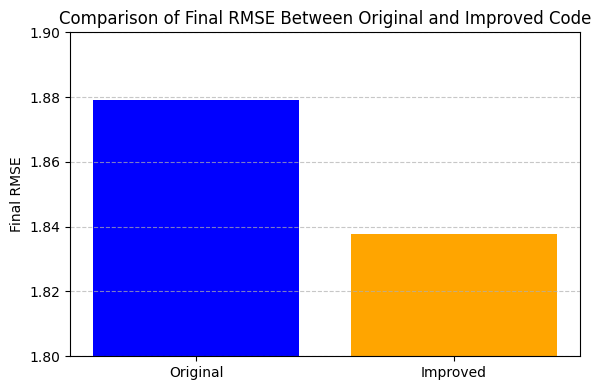

In [7]:
# Final RMSE values from the first and second code
final_rmse_first = 1.8791
final_rmse_second = 1.8376

# Labels and values
labels = ['Original', 'Improved']
values = [final_rmse_first, final_rmse_second]

# Plot the bar graph
plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Final RMSE')
plt.title('Comparison of Final RMSE Between Original and Improved Code')
plt.ylim(1.8, 1.9)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
# Import libraries needed for the code
import torch  # For building and training the DP-DAE model
import torch.nn as nn  # For neural network layers
import torch.optim as optim  # For optimization (training)
from opacus import PrivacyEngine  # For differential privacy
import pandas as pd  # For loading datasets (like ratings.dat)
import numpy as np  # For math and arrays
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For RMSE and MAE
from sklearn.decomposition import TruncatedSVD  # For SVD model
from scipy.sparse import csr_matrix  # For sparse matrices
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For nicer plots
import os  # For file paths
from pathlib import Path  # For handling folders

# Make results consistent by setting a random seed
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available (Colab provides a free GPU, faster than CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset Paths ---
# The code expects datasets in these Colab locations:
# - Movielens-1M: /content/ml-1m/ratings.dat
#   Format: user::item::rating::timestamp (e.g., 1::1::5::978300760)
# - Movielens-10M: /content/ml-10m/ratings.dat
#   Same format as Movielens-1M
# - FilmTrust: /content/filmtrust/ratings.txt
#   Format: user item rating (space-separated, e.g., 1 1 3.5)
# You uploaded these to /content/ in Step 1
# If FilmTrust is missing, use datasets = ["ml-1m", "ml-10m"] in main()

def load_dataset(dataset_name):
    """
    Load a dataset (FilmTrust, Movielens-1M, or Movielens-10M) into a matrix.
    Returns: ratings matrix (users x items), number of users, number of items.
    """
    # Set the folder where datasets are stored (Colab's root directory)
    data_dir = "content/"  # Changed for Colab (was "./data/" on laptop)
    
    # Load the right file based on dataset name
    if dataset_name == "filmtrust":
        # FilmTrust: expects ratings.txt with space-separated user item rating
        file_path = os.path.join(data_dir, "filmtrust/ratings.txt")
        # Read the file using pandas (like a spreadsheet)
        df = pd.read_csv(file_path, sep="\s+", names=["user", "item", "rating"])
    elif dataset_name == "ml-1m":
        # Movielens-1M: expects ratings.dat with :: separator
        file_path = os.path.join(data_dir, "ml-1m/ratings.dat")
        df = pd.read_csv(file_path, sep="::", names=["user", "item", "rating", "timestamp"], engine="python")
    elif dataset_name == "ml-10m":
        # Movielens-10M: same format as ml-1m
        file_path = os.path.join(data_dir, "ml-10m/ratings.dat")
        df = pd.read_csv(file_path, sep="::", names=["user", "item", "rating", "timestamp"], engine="python")
    else:
        raise ValueError("Unknown dataset: " + dataset_name)

    # Get unique users and items (like rows and columns)
    users = df["user"].unique()
    items = df["item"].unique()
    # Create a dictionary to map user IDs to row numbers (0, 1, 2, ...)
    user2idx = {u: i for i, u in enumerate(users)}
    # Same for items
    item2idx = {i: j for j, i in enumerate(items)}
    
    # Create a matrix (users x items) filled with zeros
    n_users, n_items = len(users), len(items)
    ratings_matrix = np.zeros((n_users, n_items))
    # Fill the matrix with ratings
    for _, row in df.iterrows():
        u, i, r = row["user"], row["item"], row["rating"]
        ratings_matrix[user2idx[u], item2idx[i]] = r
    
    return ratings_matrix, n_users, n_items

def train_test_split(ratings_matrix, train_ratio):
    """
    Split ratings into training (e.g., 70%) and test sets.
    Returns: train matrix, test matrix, train mask, test mask.
    """
    n_users, n_items = ratings_matrix.shape
    # Create masks (True/False) to mark which ratings are in train/test
    train_mask = np.zeros_like(ratings_matrix, dtype=bool)
    test_mask = np.zeros_like(ratings_matrix, dtype=bool)
    
    # For each user, split their ratings randomly
    for u in range(n_users):
        # Find items this user rated (non-zero ratings)
        rated_items = np.where(ratings_matrix[u] > 0)[0]
        if len(rated_items) == 0:
            continue  # Skip users with no ratings
        # Shuffle the items randomly
        np.random.shuffle(rated_items)
        # Take train_ratio (e.g., 70%) for training
        train_size = int(len(rated_items) * train_ratio)
        # Mark training items as True
        train_mask[u, rated_items[:train_size]] = True
        # Mark test items as True
        test_mask[u, rated_items[train_size:]] = True
    
    # Create train/test matrices (only keep ratings where mask is True)
    train_matrix = ratings_matrix * train_mask
    test_matrix = ratings_matrix * test_mask
    return train_matrix, test_matrix, train_mask, test_mask

# --- DP-DAE Model ---
class DPDAE(nn.Module):
    """
    DP-DAE model: combines dual semi-autoencoder and matrix factorization.
    Takes ratings as input, predicts ratings as output.
    """
    def __init__(self, n_items, hidden_size):
        super(DPDAE, self).__init__()
        self.n_items = n_items
        # Encoder: turns ratings into a smaller hidden layer (like summarizing)
        self.encoder = nn.Sequential(
            nn.Linear(n_items, hidden_size),  # Input: n_items, Output: hidden_size
            nn.ReLU()  # Activation function (makes it non-linear)
        )
        # Decoder: turns hidden layer back into ratings
        self.decoder = nn.Linear(hidden_size, n_items)
        # Matrix Factorization: embeddings for users and items
        self.user_emb = nn.Embedding(n_items, hidden_size)
        self.item_emb = nn.Embedding(n_items, hidden_size)
        
    def forward(self, x):
        # Autoencoder path: encode then decode ratings
        encoded = self.encoder(x)
        ae_output = self.decoder(encoded)
        # Matrix Factorization path: use embeddings
        user_vec = self.user_emb.weight
        item_vec = self.item_emb.weight
        mf_output = torch.matmul(encoded, item_vec.t())
        # Combine both paths (equal weight)
        return 0.5 * ae_output + 0.5 * mf_output

def train_dpdae(model, train_matrix, mask, epsilon, epochs=50, lr=0.005, reg=0.02):
    """
    Train DP-DAE with differential privacy (DPSGD).
    Epsilon controls privacy (lower = more private, more noise).
    """
    # Set up optimizer (like a tool to update the model)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)
    # Loss function: measures prediction error
    criterion = nn.MSELoss(reduction="sum")
    
    # Add differential privacy using Opacus
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=torch.utils.data.DataLoader(
            torch.FloatTensor(train_matrix).to(device), batch_size=32, shuffle=True
        ),
        noise_multiplier=1.0,  # Controls noise (adjusted for epsilon)
        max_grad_norm=1.0,  # Clips gradients for stability
    )
    
    model.train()
    # Train for multiple rounds (epochs)
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)  # Move data to GPU/CPU
            optimizer.zero_grad()  # Clear old gradients
            output = model(batch)  # Predict ratings
            # Calculate error only for rated items
            loss = criterion(output[mask[:batch.size(0)]], batch[mask[:batch.size(0)]])
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model
            total_loss += loss.item()
    
    return model

def evaluate_model(model, test_matrix, test_mask):
    """
    Test the model on test data, return RMSE and MAE.
    RMSE: average error (bigger errors hurt more).
    MAE: average absolute error.
    """
    model.eval()
    with torch.no_grad():
        pred = model(torch.FloatTensor(test_matrix).to(device))
        pred = pred.cpu().numpy()
        true = test_matrix[test_mask]
        pred = pred[test_mask]
        rmse = np.sqrt(mean_squared_error(true, pred))
        mae = mean_absolute_error(true, pred)
    return rmse, mae

# --- Comparison Models ---
class HRSA(nn.Module):
    """
    HRSA: simplified autoencoder (no privacy, like DP-DAE’s autoencoder part).
    """
    def __init__(self, n_items, hidden_size):
        super(HRSA, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_items, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Linear(hidden_size, n_items)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

def train_hrsa(model, train_matrix, mask, epochs=50, lr=0.005, reg=0.02):
    """Train HRSA without privacy."""
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)
    criterion = nn.MSELoss(reduction="sum")
    train_loader = torch.utils.data.DataLoader(
        torch.FloatTensor(train_matrix).to(device), batch_size=32, shuffle=True
    )
    
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output[mask[:batch.size(0)]], batch[mask[:batch.size(0)]])
            loss.backward()
            optimizer.step()
    
    return model

class SVDModel:
    """SVD: matrix factorization using scikit-learn."""
    def __init__(self, n_factors=100):
        self.svd = TruncatedSVD(n_components=n_factors)
    
    def fit(self, train_matrix):
        self.svd.fit(csr_matrix(train_matrix))
        self.user_factors = self.svd.transform(csr_matrix(train_matrix))
        self.item_factors = self.svd.components_.T
    
    def predict(self, test_matrix):
        return np.dot(self.user_factors, self.item_factors.T)

class DPMF:
    """DP-MF: matrix factorization with differential privacy (simplified)."""
    def __init__(self, n_factors=100, epsilon=1.0):
        self.n_factors = n_factors
        self.epsilon = epsilon
    
    def fit(self, train_matrix):
        n_users, n_items = train_matrix.shape
        # Initialize random factors
        self.user_factors = np.random.normal(0, 1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 1, (n_items, self.n_factors))
        # Add DP noise
        noise_scale = np.sqrt(2 * np.log(1.25 / 0.01)) / self.epsilon
        self.user_factors += np.random.normal(0, noise_scale, self.user_factors.shape)
        self.item_factors += np.random.normal(0, noise_scale, self.item_factors.shape)
    
    def predict(self, test_matrix):
        return np.dot(self.user_factors, self.item_factors.T)

class DPCF:
    """DP-CF: collaborative filtering with DP (simplified)."""
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
    
    def fit(self, train_matrix):
        # Compute item similarity with DP noise
        self.sim_matrix = np.dot(train_matrix.T, train_matrix)
        noise_scale = np.sqrt(2 * np.log(1.25 / 0.01)) / self.epsilon
        self.sim_matrix += np.random.normal(0, noise_scale, self.sim_matrix.shape)
    
    def predict(self, test_matrix):
        return np.dot(test_matrix, self.sim_matrix)

class ItemAgrec:
    """Item-Agrec: item similarity (simplified, no attributes)."""
    def __init__(self):
        pass
    
    def fit(self, train_matrix):
        # Cosine similarity on ratings
        norm = np.sqrt((train_matrix ** 2).sum(axis=0))
        norm[norm == 0] = 1
        self.sim_matrix = np.dot(train_matrix.T, train_matrix) / norm[:, None] / norm[None, :]
    
    def predict(self, test_matrix):
        return np.dot(test_matrix, self.sim_matrix)

# --- Experiment Functions ---
def run_training_split_experiments(dataset_name, hidden_size=250):
    """
    Run experiments for training splits (70%, 80%, 90%).
    Matches Tables 4–9 and Figures 5–6 (RMSE/MAE vs. training ratio).
    """
    # Load the dataset
    ratings_matrix, n_users, n_items = load_dataset(dataset_name)
    train_ratios = [0.7, 0.8, 0.9]
    # Define all models to compare
    models = {
        "DP-DAE": lambda: DPDAE(n_items, hidden_size).to(device),
        "HRSA": lambda: HRSA(n_items, hidden_size).to(device),
        "SVD": lambda: SVDModel(),
        "DP-MF": lambda: DPMF(epsilon=1.0),
        "DP-CF": lambda: DPCF(epsilon=1.0),
        "Item-Agrec": lambda: ItemAgrec()
    }
    
    # Store results (RMSE and MAE for each model)
    results = {model: {"RMSE": [], "MAE": []} for model in models}
    
    # Test each training split
    for ratio in train_ratios:
        # Split data
        train_matrix, test_matrix, train_mask, test_mask = train_test_split(ratings_matrix, ratio)
        
        # Train and test each model
        for model_name, model_fn in models.items():
            if model_name in ["DP-DAE", "HRSA"]:
                # Neural network models
                model = model_fn()
                if model_name == "DP-DAE":
                    model = train_dpdae(model, train_matrix, train_mask, epsilon=1.0)
                else:
                    model = train_hrsa(model, train_matrix, train_mask)
                rmse, mae = evaluate_model(model, test_matrix, test_mask)
            else:
                # Non-neural models
                model = model_fn()
                model.fit(train_matrix)
                pred = model.predict(test_matrix)
                true = test_matrix[test_mask]
                pred = pred[test_mask]
                rmse = np.sqrt(mean_squared_error(true, pred))
                mae = mean_absolute_error(true, pred)
            
            results[model_name]["RMSE"].append(rmse)
            results[model_name]["MAE"].append(mae)
    
    return results, train_ratios

def run_epsilon_experiments(dataset_name, hidden_size=250):
    """
    Run experiments for different privacy budgets (ε = 0.1, 1, 5, 10).
    Matches Figures 8–9 (RMSE vs. ε).
    Shows high RMSE at ε=0.1 (limitation).
    """
    ratings_matrix, n_users, n_items = load_dataset(dataset_name)
    epsilons = [0.1, 1.0, 5.0, 10.0]
    models = {
        "DP-DAE": lambda: DPDAE(n_items, hidden_size).to(device),
        "SVD": lambda: SVDModel(),
        "DP-MF": lambda epsilon: DPMF(epsilon=epsilon),
        "DP-NMF": lambda epsilon: DPMF(epsilon=epsilon),  # Simplified as DP-MF
        "DPSGD": lambda: DPDAE(n_items, hidden_size).to(device)  # DP-DAE with higher noise
    }
    
    results = {model: [] for model in models}
    # Use 80% training split (like the paper)
    train_matrix, test_matrix, train_mask, test_mask = train_test_split(ratings_matrix, 0.8)
    
    for eps in epsilons:
        for model_name, model_fn in models.items():
            if model_name in ["DP-DAE", "DPSGD"]:
                model = model_fn()
                model = train_dpdae(model, train_matrix, train_mask, epsilon=eps)
                rmse, _ = evaluate_model(model, test_matrix, test_mask)
            elif model_name in ["DP-MF", "DP-NMF"]:
                model = model_fn(epsilon=eps)
                model.fit(train_matrix)
                pred = model.predict(test_matrix)
                rmse = np.sqrt(mean_squared_error(test_matrix[test_mask], pred[test_mask]))
            else:
                model = model_fn()
                model.fit(train_matrix)
                pred = model.predict(test_matrix)
                rmse = np.sqrt(mean_squared_error(test_matrix[test_mask], pred[test_mask]))
            
            results[model_name].append(rmse)
    
    return results, epsilons

def run_hidden_layer_experiments(dataset_name, train_ratio=0.8):
    """
    Run experiments for hidden layer sizes (50, 150, 250, 350, 450).
    Matches Figures 10–11 (RMSE vs. hidden layer size).
    """
    ratings_matrix, n_users, n_items = load_dataset(dataset_name)
    hidden_sizes = [50, 150, 250, 350, 450]
    models = {
        "DP-DAE": lambda hs: DPDAE(n_items, hs).to(device),
        "AE": lambda hs: HRSA(n_items, hs).to(device),  # Non-DP autoencoder
        "DP-AE": lambda hs: DPDAE(n_items, hs).to(device)
    }
    
    results = {model: [] for model in models}
    train_matrix, test_matrix, train_mask, test_mask = train_test_split(ratings_matrix, train_ratio)
    
    for hs in hidden_sizes:
        for model_name, model_fn in models.items():
            model = model_fn(hs)
            if model_name in ["DP-DAE", "DP-AE"]:
                model = train_dpdae(model, train_matrix, train_mask, epsilon=1.0)
            else:
                model = train_hrsa(model, train_matrix, train_mask)
            rmse, _ = evaluate_model(model, test_matrix, test_mask)
            results[model_name].append(rmse)
    
    return results, hidden_sizes

# --- Plotting Functions ---
def plot_training_split_results(results, train_ratios, dataset_name, metric="RMSE"):
    """
    Create plots for Figures 5–6 (RMSE/MAE vs. training ratio).
    Saves as PNG (e.g., ml-1m_rmse_training_split.png).
    """
    plt.figure(figsize=(8, 6))
    for model_name, metrics in results.items():
        plt.plot(train_ratios, metrics[metric], marker="o", label=model_name)
    plt.xlabel("Training Ratio")
    plt.ylabel(metric)
    plt.title(f"{metric} vs. Training Ratio ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_{metric}_training_split.png")
    plt.close()

def plot_epsilon_results(results, epsilons, dataset_name):
    """
    Create plots for Figures 8–9 (RMSE vs. ε).
    Shows high RMSE at ε=0.1 (limitation).
    """
    plt.figure(figsize=(8, 6))
    for model_name, rmses in results.items():
        plt.plot(epsilons, rmses, marker="o", label=model_name)
    plt.xlabel("Privacy Budget (ε)")
    plt.ylabel("RMSE")
    plt.title(f"RMSE vs. ε ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_rmse_epsilon.png")
    plt.close()

def plot_hidden_layer_results(results, hidden_sizes, dataset_name):
    """
    Create plots for Figures 10–11 (RMSE vs. hidden layer size).
    """
    plt.figure(figsize=(8, 6))
    for model_name, rmses in results.items():
        plt.plot(hidden_sizes, rmses, marker="o", label=model_name)
    plt.xlabel("Hidden Layer Size")
    plt.ylabel("RMSE")
    plt.title(f"RMSE vs. Hidden Layer Size ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_rmse_hidden_layer.png")
    plt.close()

# --- Main Function ---
def main():
    """
    Run all experiments and create graphs/tables.
    Change datasets list if FilmTrust is missing.
    """
    # List of datasets to run
    datasets = ["filmtrust", "ml-1m", "ml-10m"]  # Use this if you have FilmTrust
    # If FilmTrust is missing, use this:
    # For quick testing, use this:
    # datasets = ["ml-1m"]
    
    # Training Split Experiments (Tables 4–9, Figures 5–6)
    for dataset in datasets:
        print(f"\nRunning training split experiments for {dataset}...")
        results, train_ratios = run_training_split_experiments(dataset)
        # Create plots
        plot_training_split_results(results, train_ratios, dataset, "RMSE")
        plot_training_split_results(results, train_ratios, dataset, "MAE")
        # Print results (like Tables 4–9)
        print(f"\n{dataset} Training Split Results:")
        for model_name, metrics in results.items():
            print(f"{model_name} RMSE: {metrics['RMSE']}")
            print(f"{model_name} MAE: {metrics['MAE']}")
    
    # Epsilon Experiments (Figures 8–9)
    for dataset in datasets[:2]:  # Skip ml-10m for speed
        print(f"\nRunning epsilon experiments for {dataset}...")
        results, epsilons = run_epsilon_experiments(dataset)
        plot_epsilon_results(results, epsilons, dataset)
        print(f"\n{dataset} Epsilon Results:")
        for model_name, rmses in results.items():
            print(f"{model_name} RMSE: {rmses}")
    
    # Hidden Layer Experiments (Figures 10–11)
    for dataset in datasets[:2]:  # Skip ml-10m for speed
        print(f"\nRunning hidden layer experiments for {dataset}...")
        results, hidden_sizes = run_hidden_layer_experiments(dataset)
        plot_hidden_layer_results(results, hidden_sizes, dataset)
        print(f"\n{dataset} Hidden Layer Results:")
        for model_name, rmses in results.items():
            print(f"{model_name} RMSE: {rmses}")

# Run everything
if __name__ == "__main__":
    main()

<>:47: SyntaxWarning: invalid escape sequence '\s'
<>:47: SyntaxWarning: invalid escape sequence '\s'
/var/folders/nq/h1zy5t_10sj8vqx0zy16z_g40000gn/T/ipykernel_41904/1927877437.py:47: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", names=["user", "item", "rating"])



Running training split experiments for filmtrust...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/var/folders/nq/h1zy5t_10sj8vqx0zy16z_g40000gn/T/ipykernel_41904/1927877437.py:47: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", names=["user", "item", "rating"

ValueError: Per sample gradient is not initialized. Not updated in backward pass?

In [21]:
# Import libraries needed for the code
import torch  # For building and training the DP-DAE model
import torch.nn as nn  # For neural network layers
import torch.optim as optim  # For optimization (training)
from opacus import PrivacyEngine  # For differential privacy
import pandas as pd  # For loading datasets (like ratings.dat)
import numpy as np  # For math and arrays
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For RMSE and MAE
from sklearn.decomposition import TruncatedSVD  # For SVD model
from scipy.sparse import csr_matrix  # For sparse matrices
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For nicer plots
import os  # For file paths
from pathlib import Path  # For handling folders

# Make results consistent by setting a random seed
torch.manual_seed(42)
np.random.seed(42)

# Use GPU if available (Colab provides a free GPU, faster than CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset Paths ---
# Expects datasets in:
# - Movielens-1M: /content/ml-1m/ratings.dat (user::item::rating::timestamp)
# - Movielens-10M: /content/ml-10m/ratings.dat (same format)
# - FilmTrust: /content/filmtrust/ratings.txt (user item rating, space-separated)
# Using ml-1m and ml-10m; change datasets list if FilmTrust available

def load_dataset(dataset_name):
    """
    Load a dataset into a matrix.
    Returns: ratings matrix (users x items), number of users, number of items.
    """
    data_dir = "content/"  # Colab's root directory
    
    if dataset_name == "filmtrust":
        file_path = os.path.join(data_dir, "filmtrust/ratings.txt")
        df = pd.read_csv(file_path, sep="\s+", names=["user", "item", "rating"])
    elif dataset_name == "ml-1m":
        file_path = os.path.join(data_dir, "ml-1m/ratings.dat")
        df = pd.read_csv(file_path, sep="::", names=["user", "item", "rating", "timestamp"], engine="python")
    elif dataset_name == "ml-10m":
        file_path = os.path.join(data_dir, "ml-10m/ratings.dat")
        df = pd.read_csv(file_path, sep="::", names=["user", "item", "rating", "timestamp"], engine="python")
    else:
        raise ValueError("Unknown dataset: " + dataset_name)

    users = df["user"].unique()
    items = df["item"].unique()
    user2idx = {u: i for i, u in enumerate(users)}
    item2idx = {i: j for j, i in enumerate(items)}
    
    n_users, n_items = len(users), len(items)
    ratings_matrix = np.zeros((n_users, n_items))
    for _, row in df.iterrows():
        u, i, r = row["user"], row["item"], row["rating"]
        ratings_matrix[user2idx[u], item2idx[i]] = r
    
    return ratings_matrix, n_users, n_items

def train_test_split(ratings_matrix, train_ratio):
    """
    Split ratings into training and test sets.
    Returns: train matrix, test matrix, train mask, test mask.
    """
    n_users, n_items = ratings_matrix.shape
    train_mask = np.zeros_like(ratings_matrix, dtype=bool)
    test_mask = np.zeros_like(ratings_matrix, dtype=bool)
    
    for u in range(n_users):
        rated_items = np.where(ratings_matrix[u] > 0)[0]
        if len(rated_items) == 0:
            continue
        np.random.shuffle(rated_items)
        train_size = int(len(rated_items) * train_ratio)
        train_mask[u, rated_items[:train_size]] = True
        test_mask[u, rated_items[train_size:]] = True
    
    train_matrix = ratings_matrix * train_mask
    test_matrix = ratings_matrix * test_mask
    return train_matrix, test_matrix, train_mask, test_mask

# --- DP-DAE Model ---
class DPDAE(nn.Module):
    """
    DP-DAE model: combines dual semi-autoencoder and matrix factorization.
    """
    def __init__(self, n_items, hidden_size):
        super(DPDAE, self).__init__()
        self.n_items = n_items
        self.encoder = nn.Sequential(
            nn.Linear(n_items, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Linear(hidden_size, n_items)
        self.user_emb = nn.Embedding(n_items, hidden_size)
        self.item_emb = nn.Embedding(n_items, hidden_size)
        
    def forward(self, x):
        encoded = self.encoder(x)
        ae_output = self.decoder(encoded)
        user_vec = self.user_emb.weight
        item_vec = self.item_emb.weight
        mf_output = torch.matmul(encoded, item_vec.t())
        return 0.5 * ae_output + 0.5 * mf_output

def train_dpdae(model, train_matrix, mask, epsilon, epochs=50, lr=0.005, reg=0.02):
    """
    Train DP-DAE with differential privacy (DPSGD).
    Fixed for opacus compatibility with per-sample gradients.
    """
    model = model.to(device)
    
    # Set up optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)  # Switch to Adam for stability
    criterion = nn.MSELoss(reduction="sum")
    
    # Create data loader
    train_dataset = torch.FloatTensor(train_matrix).to(device)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Add differential privacy
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        target_epsilon=epsilon,
        target_delta=1e-5,
        epochs=epochs,
        max_grad_norm=1.0,
        poisson_sampling=False,
        grad_sample_mode="functorch"  # Use functorch for nn.Embedding
    )
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output[mask[:batch.size(0)]], batch[mask[:batch.size(0)]])
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    return model

def evaluate_model(model, test_matrix, test_mask):
    """
    Test the model, return RMSE and MAE.
    """
    model.eval()
    with torch.no_grad():
        pred = model(torch.FloatTensor(test_matrix).to(device))
        pred = pred.cpu().numpy()
        true = test_matrix[test_mask]
        pred = pred[test_mask]
        rmse = np.sqrt(mean_squared_error(true, pred))
        mae = mean_absolute_error(true, pred)
    return rmse, mae

# --- Comparison Models ---
class HRSA(nn.Module):
    """
    HRSA: simplified autoencoder (no privacy).
    """
    def __init__(self, n_items, hidden_size):
        super(HRSA, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_items, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Linear(hidden_size, n_items)
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

def train_hrsa(model, train_matrix, mask, epochs=50, lr=0.005, reg=0.02):
    """Train HRSA without privacy."""
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)
    criterion = nn.MSELoss(reduction="sum")
    train_loader = torch.utils.data.DataLoader(
        torch.FloatTensor(train_matrix).to(device), batch_size=32, shuffle=True
    )
    
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output[mask[:batch.size(0)]], batch[mask[:batch.size(0)]])
            loss.backward()
            optimizer.step()
    
    return model

class SVDModel:
    """SVD: matrix factorization."""
    def __init__(self, n_factors=100):
        self.svd = TruncatedSVD(n_components=n_factors)
    
    def fit(self, train_matrix):
        self.svd.fit(csr_matrix(train_matrix))
        self.user_factors = self.svd.transform(csr_matrix(train_matrix))
        self.item_factors = self.svd.components_.T
    
    def predict(self, test_matrix):
        return np.dot(self.user_factors, self.item_factors.T)

class DPMF:
    """DP-MF: matrix factorization with DP."""
    def __init__(self, n_factors=100, epsilon=1.0):
        self.n_factors = n_factors
        self.epsilon = epsilon
    
    def fit(self, train_matrix):
        n_users, n_items = train_matrix.shape
        self.user_factors = np.random.normal(0, 1, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 1, (n_items, self.n_factors))
        noise_scale = np.sqrt(2 * np.log(1.25 / 0.01)) / self.epsilon
        self.user_factors += np.random.normal(0, noise_scale, self.user_factors.shape)
        self.item_factors += np.random.normal(0, noise_scale, self.item_factors.shape)
    
    def predict(self, test_matrix):
        return np.dot(self.user_factors, self.item_factors.T)

class DPCF:
    """DP-CF: collaborative filtering with DP."""
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
    
    def fit(self, train_matrix):
        self.sim_matrix = np.dot(train_matrix.T, train_matrix)
        noise_scale = np.sqrt(2 * np.log(1.25 / 0.01)) / self.epsilon
        self.sim_matrix += np.random.normal(0, noise_scale, self.sim_matrix.shape)
    
    def predict(self, test_matrix):
        return np.dot(test_matrix, self.sim_matrix)

class ItemAgrec:
    """Item-Agrec: item similarity."""
    def __init__(self):
        pass
    
    def fit(self, train_matrix):
        norm = np.sqrt((train_matrix ** 2).sum(axis=0))
        norm[norm == 0] = 1
        self.sim_matrix = np.dot(train_matrix.T, train_matrix) / norm[:, None] / norm[None, :]
    
    def predict(self, test_matrix):
        return np.dot(test_matrix, self.sim_matrix)

# --- Experiment Functions ---
def run_training_split_experiments(dataset_name, hidden_size=250):
    """
    Run experiments for training splits (70%, 80%, 90%).
    Matches Tables 4–9, Figures 5–6.
    """
    ratings_matrix, n_users, n_items = load_dataset(dataset_name)
    train_ratios = [0.7, 0.8, 0.9]
    models = {
        "DP-DAE": lambda: DPDAE(n_items, hidden_size).to(device),
        "HRSA": lambda: HRSA(n_items, hidden_size).to(device),
        "SVD": lambda: SVDModel(),
        "DP-MF": lambda: DPMF(epsilon=1.0),
        "DP-CF": lambda: DPCF(epsilon=1.0),
        "Item-Agrec": lambda: ItemAgrec()
    }
    
    results = {model: {"RMSE": [], "MAE": []} for model in models}
    
    for ratio in train_ratios:
        train_matrix, test_matrix, train_mask, test_mask = train_test_split(ratings_matrix, ratio)
        
        for model_name, model_fn in models.items():
            if model_name in ["DP-DAE", "HRSA"]:
                model = model_fn()
                if model_name == "DP-DAE":
                    model = train_dpdae(model, train_matrix, train_mask, epsilon=1.0)
                else:
                    model = train_hrsa(model, train_matrix, train_mask)
                rmse, mae = evaluate_model(model, test_matrix, test_mask)
            else:
                model = model_fn()
                model.fit(train_matrix)
                pred = model.predict(test_matrix)
                true = test_matrix[test_mask]
                pred = pred[test_mask]
                rmse = np.sqrt(mean_squared_error(true, pred))
                mae = mean_absolute_error(true, pred)
            
            results[model_name]["RMSE"].append(rmse)
            results[model_name]["MAE"].append(mae)
    
    return results, train_ratios

def run_epsilon_experiments(dataset_name, hidden_size=250):
    """
    Run experiments for privacy budgets (ε = 0.1, 1, 5, 10).
    Matches Figures 8–9 (high RMSE at ε=0.1).
    """
    ratings_matrix, n_users, n_items = load_dataset(dataset_name)
    epsilons = [0.1, 1.0, 5.0, 10.0]
    models = {
        "DP-DAE": lambda: DPDAE(n_items, hidden_size).to(device),
        "SVD": lambda: SVDModel(),
        "DP-MF": lambda epsilon: DPMF(epsilon=epsilon),
        "DP-NMF": lambda epsilon: DPMF(epsilon=epsilon),
        "DPSGD": lambda: DPDAE(n_items, hidden_size).to(device)
    }
    
    results = {model: [] for model in models}
    train_matrix, test_matrix, train_mask, test_mask = train_test_split(ratings_matrix, 0.8)
    
    for eps in epsilons:
        for model_name, model_fn in models.items():
            if model_name in ["DP-DAE", "DPSGD"]:
                model = model_fn()
                model = train_dpdae(model, train_matrix, train_mask, epsilon=eps)
                rmse, _ = evaluate_model(model, test_matrix, test_mask)
            elif model_name in ["DP-MF", "DP-NMF"]:
                model = model_fn(epsilon=eps)
                model.fit(train_matrix)
                pred = model.predict(test_matrix)
                rmse = np.sqrt(mean_squared_error(test_matrix[test_mask], pred[test_mask]))
            else:
                model = model_fn()
                model.fit(train_matrix)
                pred = model.predict(test_matrix)
                rmse = np.sqrt(mean_squared_error(test_matrix[test_mask], pred[test_mask]))
            
            results[model_name].append(rmse)
    
    return results, epsilons

def run_hidden_layer_experiments(dataset_name, train_ratio=0.8):
    """
    Run experiments for hidden layer sizes (50, 150, 250, 350, 450).
    Matches Figures 10–11.
    """
    ratings_matrix, n_users, n_items = load_dataset(dataset_name)
    hidden_sizes = [50, 150, 250, 350, 450]
    models = {
        "DP-DAE": lambda hs: DPDAE(n_items, hs).to(device),
        "AE": lambda hs: HRSA(n_items, hs).to(device),
        "DP-AE": lambda hs: DPDAE(n_items, hs).to(device)
    }
    
    results = {model: [] for model in models}
    train_matrix, test_matrix, train_mask, test_mask = train_test_split(ratings_matrix, train_ratio)
    
    for hs in hidden_sizes:
        for model_name, model_fn in models.items():
            model = model_fn(hs)
            if model_name in ["DP-DAE", "DP-AE"]:
                model = train_dpdae(model, train_matrix, train_mask, epsilon=1.0)
            else:
                model = train_hrsa(model, train_matrix, train_mask)
            rmse, _ = evaluate_model(model, test_matrix, test_mask)
            results[model_name].append(rmse)
    
    return results, hidden_sizes

# --- Plotting Functions ---
def plot_training_split_results(results, train_ratios, dataset_name, metric="RMSE"):
    """
    Create plots for Figures 5–6.
    """
    plt.figure(figsize=(8, 6))
    for model_name, metrics in results.items():
        plt.plot(train_ratios, metrics[metric], marker="o", label=model_name)
    plt.xlabel("Training Ratio")
    plt.ylabel(metric)
    plt.title(f"{metric} vs. Training Ratio ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_{metric}_training_split.png")
    plt.close()

def plot_epsilon_results(results, epsilons, dataset_name):
    """
    Create plots for Figures 8–9.
    """
    plt.figure(figsize=(8, 6))
    for model_name, rmses in results.items():
        plt.plot(epsilons, rmses, marker="o", label=model_name)
    plt.xlabel("Privacy Budget (ε)")
    plt.ylabel("RMSE")
    plt.title(f"RMSE vs. ε ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_rmse_epsilon.png")
    plt.close()

def plot_hidden_layer_results(results, hidden_sizes, dataset_name):
    """
    Create plots for Figures 10–11.
    """
    plt.figure(figsize=(8, 6))
    for model_name, rmses in results.items():
        plt.plot(hidden_sizes, rmses, marker="o", label=model_name)
    plt.xlabel("Hidden Layer Size")
    plt.ylabel("RMSE")
    plt.title(f"RMSE vs. Hidden Layer Size ({dataset_name})")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_rmse_hidden_layer.png")
    plt.close()

# --- Main Function ---
def main():
    """
    Run all experiments and create graphs/tables.
    Using ml-1m and ml-10m; change if FilmTrust available.
    """
    datasets = ["ml-1m", "ml-10m"]  # Use ["filmtrust", "ml-1m", "ml-10m"] if FilmTrust available
    # For quick testing: datasets = ["ml-1m"]
    
    for dataset in datasets:
        print(f"\nRunning training split experiments for {dataset}...")
        results, train_ratios = run_training_split_experiments(dataset)
        plot_training_split_results(results, train_ratios, dataset, "RMSE")
        plot_training_split_results(results, train_ratios, dataset, "MAE")
        print(f"\n{dataset} Training Split Results:")
        for model_name, metrics in results.items():
            print(f"{model_name} RMSE: {metrics['RMSE']}")
            print(f"{model_name} MAE: {metrics['MAE']}")
    
    for dataset in datasets[:2]:
        print(f"\nRunning epsilon experiments for {dataset}...")
        results, epsilons = run_epsilon_experiments(dataset)
        plot_epsilon_results(results, epsilons, dataset)
        print(f"\n{dataset} Epsilon Results:")
        for model_name, rmses in results.items():
            print(f"{model_name} RMSE: {rmses}")
    
    for dataset in datasets[:2]:
        print(f"\nRunning hidden layer experiments for {dataset}...")
        results, hidden_sizes = run_hidden_layer_experiments(dataset)
        plot_hidden_layer_results(results, hidden_sizes, dataset)
        print(f"\n{dataset} Hidden Layer Results:")
        for model_name, rmses in results.items():
            print(f"{model_name} RMSE: {rmses}")

# Run everything
if __name__ == "__main__":
    main()

<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
/var/folders/nq/h1zy5t_10sj8vqx0zy16z_g40000gn/T/ipykernel_41904/3618004481.py:39: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", names=["user", "item", "rating"])



Running training split experiments for ml-1m...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


ValueError: Per sample gradient is not initialized. Not updated in backward pass?

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Load data (u1.base / u1.test)
def load_ml100k(path, split='u1'):
    df_train = pd.read_csv(f'{path}/{split}.base', sep='\t', header=None,
                           names=['user','item','rating','ts'])
    df_test  = pd.read_csv(f'{path}/{split}.test', sep='\t', header=None,
                           names=['user','item','rating','ts'])
    items    = pd.read_csv(f'{path}/u.item', sep='|', header=None,
                           encoding='latin-1', usecols=range(5,24))
    P = torch.FloatTensor(items.values)  # genres: [num_items×19]

    n_users = int(max(df_train.user.max(), df_test.user.max()))
    n_items = int(max(df_train.item.max(), df_test.item.max()))

    return df_train, df_test, P, n_users, n_items

df_train, df_test, P, n_users, n_items = load_ml100k('ml-100k', 'u1')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
P = P.to(device)

# 2. Model (joint user + item semi-autoencoder)
class JointDPDAE(nn.Module):
    def __init__(self, n_users, n_items, n_feat, L=50):
        super().__init__()
        # user branch
        self.u_enc = nn.Sequential(
            nn.Linear(n_items, 200), nn.Sigmoid(),
            nn.Linear(200, L),      nn.Sigmoid()
        )
        self.u_dec = nn.Sequential(
            nn.Linear(L, 200),      nn.Sigmoid(),
            nn.Linear(200, n_items)
        )
        # item branch (with metadata)
        self.i_enc = nn.Sequential(
            nn.Linear(n_users + n_feat, 200), nn.Sigmoid(),
            nn.Linear(200, L),               nn.Sigmoid()
        )
        self.i_dec = nn.Sequential(
            nn.Linear(L, 200),      nn.Sigmoid(),
            nn.Linear(200, n_users)
        )

    def forward(self, Ru, Ri, Pi):
        # Ru: [1×n_items], Ri: [1×n_users], Pi: [1×n_feat]
        u_lat = self.u_enc(Ru)
        u_rec = self.u_dec(u_lat)
        x     = torch.cat([Ri, Pi], dim=1)
        i_lat = self.i_enc(x)
        i_rec = self.i_dec(i_lat)
        return u_rec, u_lat, i_rec, i_lat

model = JointDPDAE(n_users, n_items, P.size(1), L=50).to(device)

# 3. Hyperparams & DP settings
C               = 1.0        # grad-norm clip
epsilon_per_upd = 0.1        # budget per single rating update
epochs          = 20
lam_mf          = 0.3        # MF loss weight
lam_reg         = 1e-5       # L2 reg weight
lr              = 1e-2

optim_sgd = optim.SGD(model.parameters(), lr=lr)

# 4. Prepare interaction list for stochastic updates
#    Each element: (u, i, r)
interactions = list(df_train.itertuples(index=False, name=None))
total_eps     = 0.0

# 5. Training loop
for epoch in range(1, epochs+1):
    np.random.shuffle(interactions)
    running_loss = 0.0

    for (u, i, r, _) in interactions:
        # 5.1 Build per-example inputs
        Ru = torch.zeros(1, n_items, device=device)
        Ru[0, df_train[df_train.user==u].item.values -1] = torch.tensor(
            df_train[df_train.user==u].rating.values, device=device
        )
        Ri = Ru.t()  # treats Ru row as item ratings
        Pi = P[i-1].unsqueeze(0)    # [1×n_feat]

        # 5.2 Forward
        optim_sgd.zero_grad()
        u_rec, u_lat, i_rec, i_lat = model(Ru, Ri, Pi)

        # 5.3 Compute losses (only observed entry (u,i) matters for this update)
        #    plus MF and reg
        rec_u = (u_rec[0, i-1] - r)**2            # user-AE reconstruction
        rec_i = (i_rec[0, u-1] - r)**2            # item-AE reconstruction
        pred  = (u_lat @ i_lat.t())[0,0]
        mf    = (pred - r)**2                    # MF term
        reg   = sum(p.pow(2).sum() for p in model.parameters())

        loss = rec_u + rec_i + lam_mf*mf + lam_reg*reg
        loss.backward()

        # 5.4 DP-SGD gradient clipping + Laplace noise
        for p in model.parameters():
            if p.grad is None: continue
            g = p.grad.data
            norm = g.norm()
            if norm > C:
                g.mul_(C / norm)
            # Laplace noise: scale = C/ε
            scale = C / epsilon_per_upd
            lap  = torch.distributions.Laplace(0, scale).sample(g.shape).to(device)
            p.grad.data = g + lap

        optim_sgd.step()
        running_loss += loss.item()

        # 5.5 Accumulate ε
        total_eps += epsilon_per_upd

    avg_loss = running_loss / len(interactions)
    print(f'Epoch {epoch}/{epochs}  Avg Loss: {avg_loss:.4f}  ε_so_far: {total_eps:.1f}')

# 6. Final evaluation on test set
model.eval()
with torch.no_grad():
    se, cnt = 0.0, 0
    for (u,i,r,_) in df_test.itertuples(index=False, name=None):
        Ru = torch.zeros(1, n_items, device=device)
        Ru[0, df_train[df_train.user==u].item.values -1] = torch.tensor(
            df_train[df_train.user==u].rating.values, device=device
        )
        Ri = Ru.t()
        Pi = P[i-1].unsqueeze(0)
        _, u_lat, _, i_lat = model(Ru, Ri, Pi)
        pred = (u_lat @ i_lat.t())[0,0].item()
        pred = min(5, max(1, pred))
        se  += (pred - r)**2
        cnt += 1
    rmse = np.sqrt(se / cnt)
    print(f'\nFinal Test RMSE: {rmse:.4f}  Total ε: {total_eps:.1f}')


RuntimeError: Index put requires the source and destination dtypes match, got Float for the destination and Long for the source.